In [56]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Analytical Tools
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 0 Run Model
(0a) Sobol - Sample Policy Space 
(0b) Sobol - Sample Uncertainty Space
(0c)...

#### 0a) Sobol - Sample Policy Space

In [57]:
%%script false --no-raise-error

# Model Settings
pf = 1
s = 1
p = 256

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate 0': 3.5,
            'ID flood wave shape': 4}
ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})

ref_scenario = Scenario('reference', **ref_dict)

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenario, policies=p, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 1 scenarios * 6144 policies * 1 model(s) = 6144 experiments
100%|██████████████████████████████████████| 6144/6144 [10:09<00:00, 10.07it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1_P256_.tar.gz


#### (0b) Sobol Sample Scenario Space

In [58]:
%%script false --no-raise-error

# Model Settings
pf = 1
s = 1000
p = 1

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Policy
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 0':0,
                                  'EWS_DaysToThreat':0})
                                  ]

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=s, policies=ref_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [01:28<00:00, 11.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1000_P1_.tar.gz


### 1 Global Sensivity Analysis

#### 1a1 Sobol (Sample Policy Space)

In [71]:
# Model Settings

#Sampling policy
pf, s, p = 1, 1, 256 

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1_P256_.tar.gz


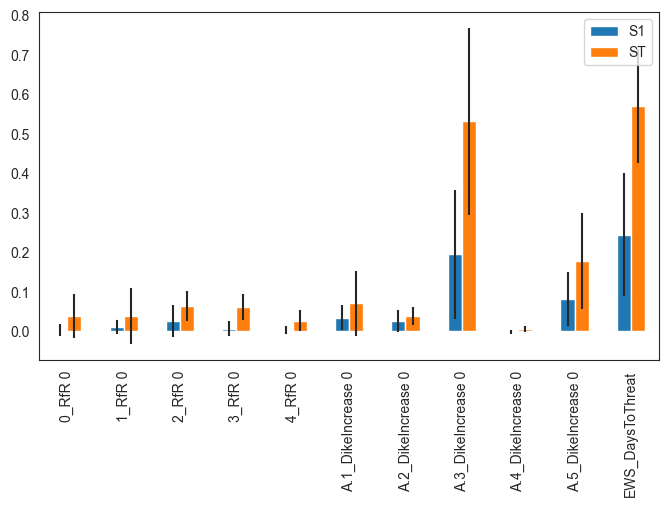

In [72]:
# Prepare Sobol Variables
#problem = get_SALib_problem(uncertainties)
problem = get_SALib_problem(levers)
outcome_var = 'Expected Number of Deaths'
Si = sobol.analyze(problem, outcomes[outcome_var], print_to_console=False)

# Process Dataframe: Filter S1+ST
Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

^ ABOVE GRAPH SHOWS POLICY THAT AFFECTS EXPECTED DEATHS

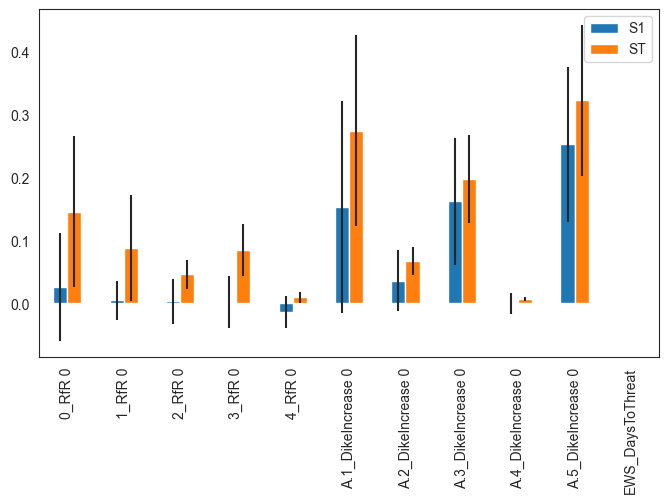

In [73]:
# Prepare Sobol Variables
#problem = get_SALib_problem(uncertainties)
problem = get_SALib_problem(levers)
outcome_var = 'Expected Annual Damage'
Si = sobol.analyze(problem, outcomes[outcome_var], print_to_console=False)

# Process Dataframe: Filter S1+ST
Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter_s1_st, index= problem['names'])

# Visualize Sobol indices
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

^ ABOVE GRAPH SHOWS POLICY THAT AFFECTS ANNUAL DAMAGE

#### 1a2 Sobol (Sample Uncertainty Space)

In [153]:
#sampling scenario
pf, s, p = 1, 1000, 1 

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

# Prepare Sobol Variables
problem = get_SALib_problem(uncertainties)
outcome_var = 'Expected Number of Deaths'

Si = sobol.analyze(problem, outcomes[outcome_var], print_to_console=False)

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1000_P1_.tar.gz


RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

#### 1b1 Feature Scoring (Uncertainty Space)

In [129]:
#sampling scenario
pf, s, p = 1, 1000, 1 

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop uncertainties
experiments.drop(columns=list(model.levers.keys()), inplace=True)

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1000_P1_.tar.gz


In [130]:
experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'scenario', 'policy',
       'model'],
      dtype='object')

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


<Axes: ylabel='0'>

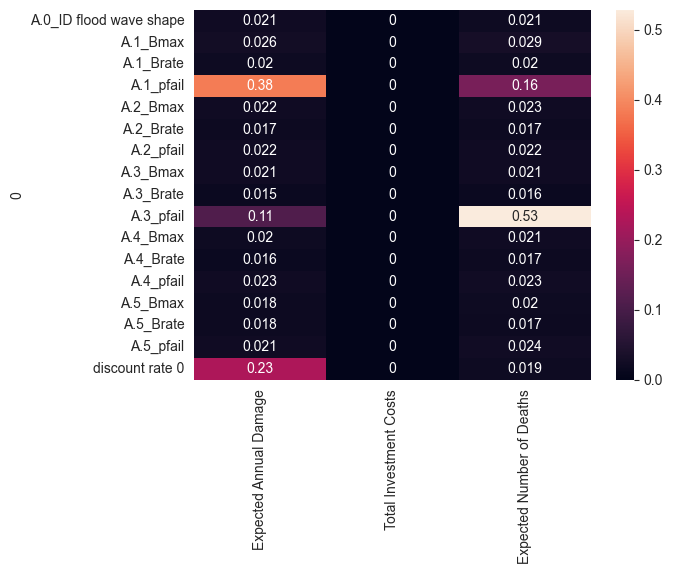

In [131]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True)

#### 1b2 Feature Scoring (Policy Space)

In [134]:
#sampling scenario
pf, s, p = 1, 1, 256 

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop policies
experiments.drop(columns=list(model.uncertainties.keys()), inplace=True)

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF1_S1_P256_.tar.gz


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


<Axes: ylabel='0'>

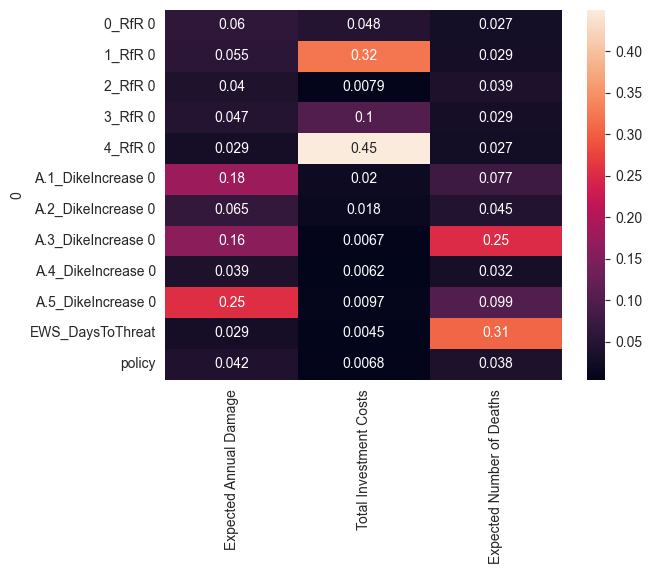

In [135]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True)

### 2 Scenario Discovery


In [70]:
from ema_workbench.analysis import prim

In [136]:
# Intialize Model
## uncertainties
## levers

# Perform Experiments 
## experiments
## outcomes
#outcome_entry
#outcome_entry[logical].shape
logical

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [180]:
# Set value range
outcome_var = 'Expected Number of Deaths'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.5)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 2000 points remaining, containing 400 cases of interest
[MainProcess/INFO] mean: 0.5826086956521739, mass: 0.0575, coverage: 0.1675, density: 0.5826086956521739 restricted_dimensions: 13


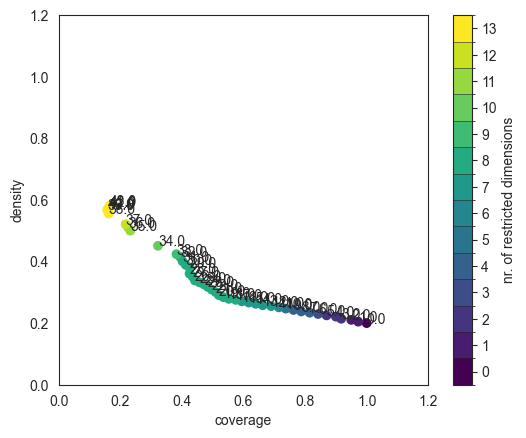

In [181]:
import matplotlib.pyplot as plt
 
box1.show_tradeoff(annotated=True)
plt.show()

coverage    0.870000
density     0.225097
id          5.000000
mass        0.773000
mean        0.225097
res_dim     2.000000
Name: 5, dtype: float64

              box 5                             
                min       max qp value  qp value
A.2_pfail  0.000353  0.855786      NaN  0.085502
A.3_pfail  0.000209  0.902409      NaN  0.146105



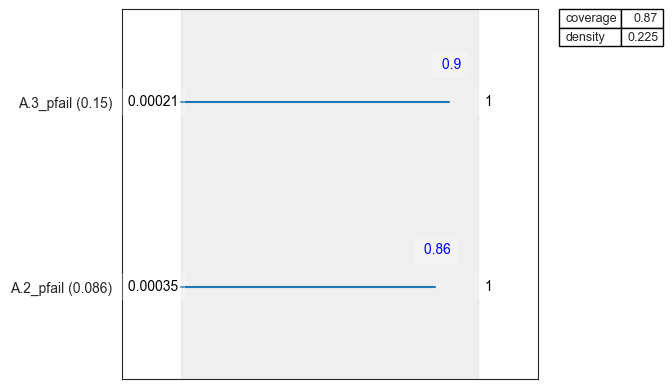

In [188]:
box1.inspect(5)
box1.inspect(5, style='graph')
plt.show()

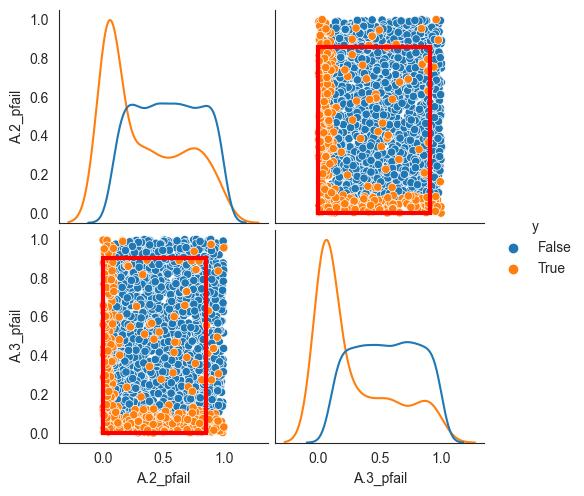

In [190]:
box1.select(5)
fig = box1.show_pairs_scatter()
plt.show()

In [ ]:
# Do dimensional stacking of results
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=5)
plt.show()